# Preprocessing Foundations for Computer Vision
- Load image datasets locally using tensorflow_datasets
- Explain why resizing is required for CNNs
- Compare preprocessing in the input pipeline vs inside the model
- Build a CPU-friendly transfer learning classifier
- Explain why preprocessing placement matters for deployment

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


In [2]:
# Load Dataset

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print("Classes:", class_names)
print("Number of classes:", num_classes)


Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of classes: 5


In [3]:
# Inspect Raw Image Sizes

for image, label in ds_train.take(3):
    print("Shape:", image.shape)


Shape: (333, 500, 3)
Shape: (212, 320, 3)
Shape: (240, 320, 3)


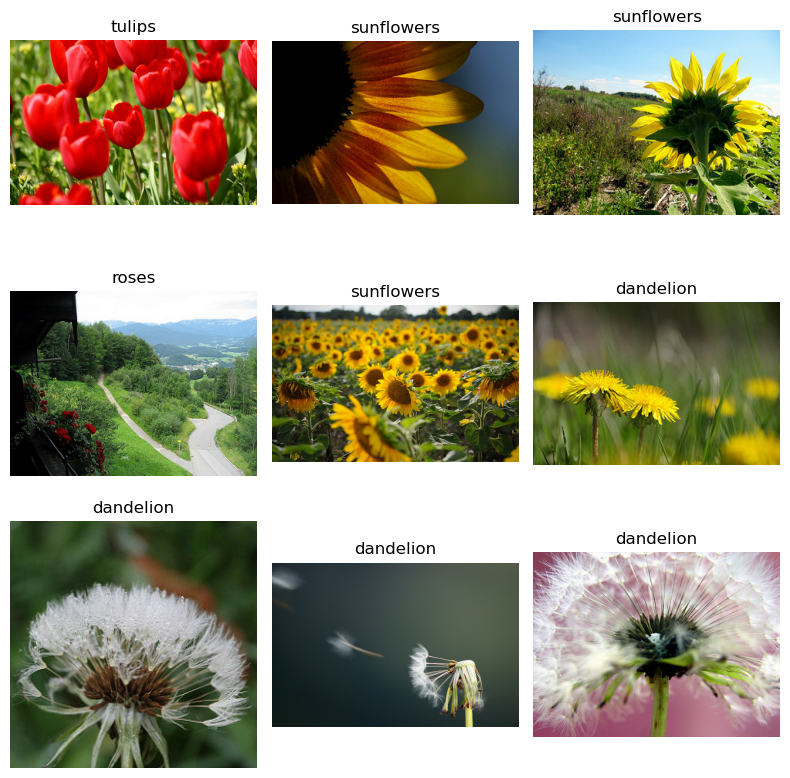

In [4]:
# Visualize Sample Images

plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Discussion:
- Are all images the same size?
- Why might this be a problem for CNNs?
- What does a CNN require about input shape?

# Approach A: Resize in the Input Pipeline

In [16]:
# Define Preprocessing Function

IMG_SIZE = (160, 160)

def preprocess_pipeline(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# Build tf.data Pipelines

BATCH_SIZE = 32

train_ds = (
    ds_train
    .map(preprocess_pipeline)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    ds_val
    .map(preprocess_pipeline)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)



In [17]:
# Build Transfer Learning Model

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [18]:
# Train Baseline

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
92/92 [==============================] - 16s 146ms/step - loss: 0.7349 - accuracy: 0.7316 - val_loss: 0.4357 - val_accuracy: 0.8488
Epoch 2/3
92/92 [==============================] - 14s 148ms/step - loss: 0.3806 - accuracy: 0.8624 - val_loss: 0.3656 - val_accuracy: 0.8733
Epoch 3/3
92/92 [==============================] - 14s 149ms/step - loss: 0.3012 - accuracy: 0.8958 - val_loss: 0.3290 - val_accuracy: 0.8801


# Approach B: Move Preprocessing Into the Model

In [19]:
# Build Model with Embedded Preprocessing

model_with_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(160, 160),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_with_preprocessing.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [20]:
# Build pipelines with minimal structural preprocessing
# Resize only to enable batching. Semantic preprocessing (normalization) happens inside the model.

def resize_only(image, label):
    image = tf.image.resize(image, (160, 160))
    return image, label

train_raw = (
    ds_train
    .map(resize_only)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_raw = (
    ds_val
    .map(resize_only)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


## Why Do We Still Resize in the Pipeline?
- Even though resizing exists in the model, tf.data.Dataset.batch() requires tensors of identical shape.
- Therefore, we must standardize image dimensions before batching.
- Model-level preprocessing does not eliminate input pipeline constraints.

## This highlights the distinction between:
- Structural preprocessing (shape, batching compatibility)
- Semantic preprocessing (normalization, augmentation, etc.)

In [21]:
# Train

history2 = model_with_preprocessing.fit(
    train_raw,
    validation_data=val_raw,
    epochs=3
)


Epoch 1/3
92/92 [==============================] - 18s 162ms/step - loss: 0.7249 - accuracy: 0.7299 - val_loss: 0.4287 - val_accuracy: 0.8447
Epoch 2/3
92/92 [==============================] - 13s 137ms/step - loss: 0.3828 - accuracy: 0.8692 - val_loss: 0.3585 - val_accuracy: 0.8760
Epoch 3/3
92/92 [==============================] - 13s 138ms/step - loss: 0.3033 - accuracy: 0.8988 - val_loss: 0.3169 - val_accuracy: 0.8896


## Discussion
- Did performance change?
- Which approach is safer for deployment?
- If we save this model and load it elsewhere, what happens?